# MIMIC 4 data - dataset construction admissions

We use the code provided by the authors of the GRU-ODE-Bayes paper to construct time series data from the mimic dataset. <br/>
https://github.com/edebrouwer/gru_ode_bayes/tree/master/data_preproc/MIMIC

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import numpy as np

In [2]:
fn = '/path/admissions.csv.gz'
adm = pd.read_csv(fn, compression='gzip')
adm.tail()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
524515,17892964,20786062,2180-09-17 00:00:00,2180-09-18 13:37:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Medicare,ENGLISH,SINGLE,WHITE,NaN,NaN,0
524516,17137572,20943099,2147-08-01 17:41:00,2147-08-02 17:30:00,NaN,EW EMER.,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,DIVORCED,HISPANIC/LATINO,2147-07-31 23:55:00,2147-08-01 19:37:00,0
524517,19389857,23176714,2189-03-01 00:58:00,2189-03-02 15:22:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
524518,12298845,22347500,2138-05-31 00:00:00,2138-06-04 16:50:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
524519,11211939,24981356,2147-08-02 15:49:00,2147-08-05 16:30:00,NaN,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,?,WIDOWED,WHITE,2147-08-02 14:27:00,2147-08-02 17:38:00,0


In [3]:
#DIFFERENCE: WE ADD THE AGE AND NOT THE DATE OF BIRTH
patients_df=pd.read_csv('/path/patients.csv.gz')
patients_df[["subject_id","anchor_age"]].head()
adm_dob=pd.merge(patients_df[["subject_id","anchor_age"]],adm,on="subject_id")

In [4]:
df=adm.groupby("subject_id")["hadm_id"].nunique()
subj_ids=list(df[df==1].index) #index of patients with only one visit.
adm_1=adm_dob.loc[adm_dob["subject_id"].isin(subj_ids)] #filter out the patients with more than one visit
print("Number of patients remaining in the dataframe: ")
print(len(adm_1.index))

Number of patients remaining in the dataframe: 
171439


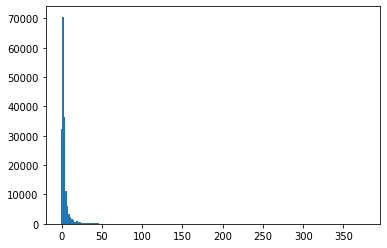

Number of patients with specific duration of admissions in days : 
 2      37970
1      32593
0      32288
4      18210
3      18184
       ...  
145        1
374        1
139        1
234        1
134        1
Name: elapsed_days, Length: 161, dtype: int64


In [5]:
#We now add a new column with the duration of each stay.
adm_1=adm_1.copy()
adm_1['admittime']=pd.to_datetime(adm_1["admittime"], format='%Y-%m-%d %H:%M:%S')
adm_1['dischtime']=pd.to_datetime(adm_1["dischtime"], format='%Y-%m-%d %H:%M:%S')

adm_1["elapsed_time"]=adm_1["dischtime"]-adm_1["admittime"]
adm_1.head()
adm_1["elapsed_days"]=adm_1["elapsed_time"].dt.days #Elapsed time in days in ICU
plt.hist(adm_1["elapsed_days"],bins=200)
plt.show()
print("Number of patients with specific duration of admissions in days : \n",adm_1["elapsed_days"].value_counts())

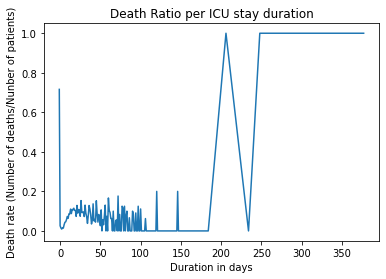

In [6]:
adm_1["deathtag"]=0
adm_1.loc[adm_1.deathtime.notnull(),"deathtag"]=1

df_deaths_per_duration=adm_1.groupby("elapsed_days")["deathtag"].sum()
df_patients_per_duration=adm_1.groupby("elapsed_days")["subject_id"].nunique()
df_death_ratio_per_duration=df_deaths_per_duration/df_patients_per_duration
plt.plot(df_death_ratio_per_duration)
plt.title("Death Ratio per ICU stay duration")
plt.xlabel("Duration in days")
plt.ylabel("Death rate (Number of deaths/Nunber of patients)")
plt.show()

In [7]:
adm_2=adm_1.loc[(adm_1["elapsed_days"]<30) & (adm_1["elapsed_days"]>2)]
print("Number of patients remaining in the dataframe: ")
print(len(adm_2.index))

Number of patients remaining in the dataframe: 
65901


In [8]:
adm_2_15=adm_2.loc[adm_2["anchor_age"]>15].copy()
print("Number of patients remaining in the dataframe: ")
print(len(adm_2_15.index))

Number of patients remaining in the dataframe: 
44037


In [9]:
fn = '/path/chartevents.csv.gz'
chartevents = pd.read_csv(fn, compression='gzip')

/nfs/homedirs/sommer/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
adm_2_15_chart=adm_2_15.loc[adm_2_15["hadm_id"].isin(chartevents['hadm_id'])].copy()
print("Number of patients remaining in the dataframe: ")
print(len(adm_2_15_chart.index))

Number of patients remaining in the dataframe: 
16572


In [11]:
df_type=adm_2_15_chart.groupby("admission_type")["subject_id"].count()
print(df_type)
adm_3 = adm_2_15_chart

admission_type
AMBULATORY OBSERVATION            1
DIRECT EMER.                    388
DIRECT OBSERVATION                3
ELECTIVE                        690
EU OBSERVATION                    5
EW EMER.                       7622
OBSERVATION ADMIT              1713
SURGICAL SAME DAY ADMISSION    2006
URGENT                         4144
Name: subject_id, dtype: int64


In [12]:
adm_3.to_csv("/path/admissions_processed.csv")